1. PREPROCESS DATA PIPELINE / CLEAN DATA 

In [3]:
import yfinance as yf
import mplfinance as mpf 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
ticker = "BX"
data = yf.download(ticker, start="2021-01-01", end="2024-01-1")
data.reset_index(drop = True, inplace = True)
data.index = data.index + 1
data

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price        Close        High         Low        Open   Volume
Ticker          BX          BX          BX          BX       BX
1        54.185383   55.991561   53.505915   55.905554  3255800
2        54.021965   54.443405   53.540316   53.652128  2758600
3        53.032864   53.987559   52.697431   53.600520  5090700
4        54.383202   54.632627   53.617726   53.763939  2368300
5        54.099369   55.062660   53.333890   54.830440  2396700
..             ...         ...         ...         ...      ...
749     126.349762  127.693599  124.947920  125.431315  3342400
750     127.007172  127.625917  126.011379  126.330422  2485000
751     128.205978  128.998738  126.243397  126.717129  3561200
752     128.708725  129.095435  127.654913  128.099643  2087900
753     126.572113  128.815072  125.953368  128.457350  2049000

[753 rows x 5 columns]

In [5]:
macro = pd.read_csv("macro.csv")
macro.index = macro.index + 1
macro

GDP  IPOs  M&A_Activities  FFR_rate
1    21058.379   118          435739      0.09
2    21058.379   118          435739      0.09
3    21058.379   118          435739      0.09
4    21058.379   118          435739      0.09
5    21058.379   118          435739      0.09
..         ...   ...             ...       ...
749  22960.600     7          299822      5.33
750  22960.600     7          299822      5.33
751  22960.600     7          299822      5.33
752  22960.600     7          299822      5.33
753  22960.600     7          299822      5.33

[753 rows x 4 columns]

In [6]:
def RSI(data, period):
    delta = data["Close"].diff()
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)
    avg_gain = gain.ewm(span=period, adjust=False).mean()
    avg_loss = loss.ewm(span=period, adjust=False).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def EMA(data, period):
    return data["Close"].ewm(span = period, adjust = False).mean()

def MACD(data, short_period = 5, long_period = 17, signal_period = 9): 
    ema_short = EMA(data, short_period)
    ema_long = EMA(data, long_period)
    macd = ema_short - ema_long
    signal = macd.ewm(span=signal_period, adjust=False).mean()
    data["MACD"] = macd
    data["Signal"] = signal
    return data 

def Bollinger_Bands(data, period = 20, std_multiplier = 2):
    middle_band = data["Close"].rolling(window=period, min_periods=1).mean()
    std = data["Close"].rolling(window=period, min_periods=1).std()
    upper_band = middle_band + (std_multiplier * std)
    lower_band = middle_band - (std_multiplier * std)
    data["MiddleBand"] = middle_band
    data["UpperBand"] = upper_band
    data["LowerBand"] = lower_band
    data["MiddleBand"] = data["MiddleBand"].fillna(0)
    data["UpperBand"] = data["UpperBand"].fillna(0)
    data["LowerBand"] = data["LowerBand"].fillna(0)
    return data



In [7]:
rsi_values = RSI(data, period=14)
data["RSI"] = rsi_values
data = MACD(data, short_period=7, long_period=17, signal_period=9)
data = Bollinger_Bands(data, period=20, std_multiplier=2)

In [8]:
data.columns = data.columns.droplevel(1)
data

Price       Close        High         Low        Open   Volume        RSI  \
1       54.185383   55.991561   53.505915   55.905554  3255800        NaN   
2       54.021965   54.443405   53.540316   53.652128  2758600   0.000000   
3       53.032864   53.987559   52.697431   53.600520  5090700   0.000000   
4       54.383202   54.632627   53.617726   53.763939  2368300  57.946856   
5       54.099369   55.062660   53.333890   54.830440  2396700  50.806544   
..            ...         ...         ...         ...      ...        ...   
749    126.349762  127.693599  124.947920  125.431315  3342400  75.149311   
750    127.007172  127.625917  126.011379  126.330422  2485000  76.146990   
751    128.205978  128.998738  126.243397  126.717129  3561200  78.004959   
752    128.708725  129.095435  127.654913  128.099643  2087900  78.803872   
753    126.572113  128.815072  125.953368  128.457350  2049000  66.889827   

Price      MACD    Signal  MiddleBand   UpperBand   LowerBand  
1      0.000000  0.000000   54.185383    0.000000    0.000000  
2     -0.022697 -0.004539   54.103674   54.334782   53.872566  
3     -0.174573 -0.038546   53.746737   54.993955   52.499520  
4     -0.083427 -0.047522   53.905853   55.106737   52.704970  
5     -0.059767 -0.049971   53.944556   54.998857   52.890256  
..          ...       ...         ...         ...         ...  
749    5.668728  5.059966  114.358659  129.893935   98.823383  
750    5.652506  5.178474  115.548777  131.133091   99.964463  
751    5.651179  5.273015  116.755814  132.334686  101.176943  
752    5.563143  5.331041  117.807682  133.642669  101.972696  
753    5.053169  5.275466  118.704379  134.383405  103.025354  

[753 rows x 11 columns]

In [9]:
data_final = data.join(macro)
data_final

Close        High         Low        Open   Volume        RSI  \
1     54.185383   55.991561   53.505915   55.905554  3255800        NaN   
2     54.021965   54.443405   53.540316   53.652128  2758600   0.000000   
3     53.032864   53.987559   52.697431   53.600520  5090700   0.000000   
4     54.383202   54.632627   53.617726   53.763939  2368300  57.946856   
5     54.099369   55.062660   53.333890   54.830440  2396700  50.806544   
..          ...         ...         ...         ...      ...        ...   
749  126.349762  127.693599  124.947920  125.431315  3342400  75.149311   
750  127.007172  127.625917  126.011379  126.330422  2485000  76.146990   
751  128.205978  128.998738  126.243397  126.717129  3561200  78.004959   
752  128.708725  129.095435  127.654913  128.099643  2087900  78.803872   
753  126.572113  128.815072  125.953368  128.457350  2049000  66.889827   

         MACD    Signal  MiddleBand   UpperBand   LowerBand        GDP  IPOs  \
1    0.000000  0.000000   54.185383    0.000000    0.000000  21058.379   118   
2   -0.022697 -0.004539   54.103674   54.334782   53.872566  21058.379   118   
3   -0.174573 -0.038546   53.746737   54.993955   52.499520  21058.379   118   
4   -0.083427 -0.047522   53.905853   55.106737   52.704970  21058.379   118   
5   -0.059767 -0.049971   53.944556   54.998857   52.890256  21058.379   118   
..        ...       ...         ...         ...         ...        ...   ...   
749  5.668728  5.059966  114.358659  129.893935   98.823383  22960.600     7   
750  5.652506  5.178474  115.548777  131.133091   99.964463  22960.600     7   
751  5.651179  5.273015  116.755814  132.334686  101.176943  22960.600     7   
752  5.563143  5.331041  117.807682  133.642669  101.972696  22960.600     7   
753  5.053169  5.275466  118.704379  134.383405  103.025354  22960.600     7   

     M&A_Activities  FFR_rate  
1            435739      0.09  
2            435739      0.09  
3            435739      0.09  
4            435739      0.09  
5            435739      0.09  
..              ...       ...  
749          299822      5.33  
750          299822      5.33  
751          299822      5.33  
752          299822      5.33  
753          299822      5.33  

[753 rows x 15 columns]

In [ ]:
#Price Signals Algorithm: 
def price_change_signals_non_overlap(data, lookahead_days=5, change_threshold_pct=0.005):
    signals = ['HOLD'] * len(data)
    i = 0
    while i < len(data):
        if i + lookahead_days < len(data):
            current_price = data['Close'].iloc[i]
            future_price = data['Close'].iloc[i + lookahead_days]
            pct_change = (future_price - current_price) / current_price
            
            if pct_change > change_threshold_pct:
                for j in range(i, min(i + lookahead_days + 1, len(data))):
                    signals[j] = 'BUY'
                i += lookahead_days + 1
                continue
            elif pct_change < -change_threshold_pct:
                for j in range(i, min(i + lookahead_days + 1, len(data))):
                    signals[j] = 'SELL'
                i += lookahead_days + 1
                continue
            else:
                signals[i] = 'HOLD'
        else:
            signals[i] = 'HOLD'
        i += 1
    data['signal'] = signals
    return data


data_final = price_change_signals_non_overlap(data_final)
data_final

Close        High         Low        Open   Volume        RSI  \
1     54.185383   55.991561   53.505915   55.905554  3255800        NaN   
2     54.021965   54.443405   53.540316   53.652128  2758600   0.000000   
3     53.032864   53.987559   52.697431   53.600520  5090700   0.000000   
4     54.383202   54.632627   53.617726   53.763939  2368300  57.946856   
5     54.099369   55.062660   53.333890   54.830440  2396700  50.806544   
..          ...         ...         ...         ...      ...        ...   
749  126.349762  127.693599  124.947920  125.431315  3342400  75.149311   
750  127.007172  127.625917  126.011379  126.330422  2485000  76.146990   
751  128.205978  128.998738  126.243397  126.717129  3561200  78.004959   
752  128.708725  129.095435  127.654913  128.099643  2087900  78.803872   
753  126.572113  128.815072  125.953368  128.457350  2049000  66.889827   

         MACD    Signal  MiddleBand   UpperBand   LowerBand        GDP  IPOs  \
1    0.000000  0.000000   54.185383    0.000000    0.000000  21058.379   118   
2   -0.022697 -0.004539   54.103674   54.334782   53.872566  21058.379   118   
3   -0.174573 -0.038546   53.746737   54.993955   52.499520  21058.379   118   
4   -0.083427 -0.047522   53.905853   55.106737   52.704970  21058.379   118   
5   -0.059767 -0.049971   53.944556   54.998857   52.890256  21058.379   118   
..        ...       ...         ...         ...         ...        ...   ...   
749  5.668728  5.059966  114.358659  129.893935   98.823383  22960.600     7   
750  5.652506  5.178474  115.548777  131.133091   99.964463  22960.600     7   
751  5.651179  5.273015  116.755814  132.334686  101.176943  22960.600     7   
752  5.563143  5.331041  117.807682  133.642669  101.972696  22960.600     7   
753  5.053169  5.275466  118.704379  134.383405  103.025354  22960.600     7   

     M&A_Activities  FFR_rate signal  
1            435739      0.09   HOLD  
2            435739      0.09   HOLD  
3            435739      0.09    BUY  
4            435739      0.09    BUY  
5            435739      0.09    BUY  
..              ...       ...    ...  
749          299822      5.33   HOLD  
750          299822      5.33   HOLD  
751          299822      5.33   HOLD  
752          299822      5.33   HOLD  
753          299822      5.33   HOLD  

[753 rows x 16 columns]

In [11]:
counts = data_final['signal'].value_counts()
print(counts)

signal
BUY     426
SELL    312
HOLD     15
Name: count, dtype: int64


In [12]:
from sklearn.preprocessing import MinMaxScaler
data_clean = data_final.dropna()
numeric_features = ['Close', 'High', 'Low', 'Open', 'Volume', 'RSI', 
                    'MACD', 'MiddleBand', 'UpperBand', 'LowerBand',
                    'GDP','IPOs','M&A_Activities','FFR_rate',
                    'signal']

In [13]:
data_clean = data_clean[numeric_features]
mapping = {"SELL": 0, "HOLD": 1, "BUY": 2}
data_clean["signal_label"] = data_clean["signal"].map(mapping)
data_clean = data_clean.drop(columns=["signal"])

In [14]:
data_clean

Close        High         Low        Open   Volume        RSI  \
2     54.021965   54.443405   53.540316   53.652128  2758600   0.000000   
3     53.032864   53.987559   52.697431   53.600520  5090700   0.000000   
4     54.383202   54.632627   53.617726   53.763939  2368300  57.946856   
5     54.099369   55.062660   53.333890   54.830440  2396700  50.806544   
6     53.918751   54.305790   53.480109   53.729534  1689100  46.591151   
..          ...         ...         ...         ...      ...        ...   
749  126.349762  127.693599  124.947920  125.431315  3342400  75.149311   
750  127.007172  127.625917  126.011379  126.330422  2485000  76.146990   
751  128.205978  128.998738  126.243397  126.717129  3561200  78.004959   
752  128.708725  129.095435  127.654913  128.099643  2087900  78.803872   
753  126.572113  128.815072  125.953368  128.457350  2049000  66.889827   

         MACD  MiddleBand   UpperBand   LowerBand        GDP  IPOs  \
2   -0.022697   54.103674   54.334782   53.872566  21058.379   118   
3   -0.174573   53.746737   54.993955   52.499520  21058.379   118   
4   -0.083427   53.905853   55.106737   52.704970  21058.379   118   
5   -0.059767   53.944556   54.998857   52.890256  21058.379   118   
6   -0.067420   53.940255   54.883486   52.997025  21058.379   118   
..        ...         ...         ...         ...        ...   ...   
749  5.668728  114.358659  129.893935   98.823383  22960.600     7   
750  5.652506  115.548777  131.133091   99.964463  22960.600     7   
751  5.651179  116.755814  132.334686  101.176943  22960.600     7   
752  5.563143  117.807682  133.642669  101.972696  22960.600     7   
753  5.053169  118.704379  134.383405  103.025354  22960.600     7   

     M&A_Activities  FFR_rate  signal_label  
2            435739      0.09             1  
3            435739      0.09             2  
4            435739      0.09             2  
5            435739      0.09             2  
6            435739      0.09             2  
..              ...       ...           ...  
749          299822      5.33             1  
750          299822      5.33             1  
751          299822      5.33             1  
752          299822      5.33             1  
753          299822      5.33             1  

[752 rows x 15 columns]

In [15]:
feature_columns = ['Close', 'High', 'Low', 'Open', 'Volume', 'RSI', 
                    'MACD', 'MiddleBand', 'UpperBand', 'LowerBand',
                    'GDP','IPOs','M&A_Activities','FFR_rate']
target_column = 'signal_label'

In [16]:
train_size = int(len(data_clean) * 0.8)
train_data_clean = data_clean.iloc[:train_size]
test_data_clean  = data_clean.iloc[train_size:]
lookback = 5

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train_data_clean[feature_columns])
train_data_clean[feature_columns] = scaler.transform(train_data_clean[feature_columns])
test_data_clean[feature_columns] = scaler.transform(test_data_clean[feature_columns])

C:\Users\phamh\AppData\Local\Temp\ipykernel_23812\3507572713.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_clean[feature_columns] = scaler.transform(train_data_clean[feature_columns])
C:\Users\phamh\AppData\Local\Temp\ipykernel_23812\3507572713.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_clean[feature_columns] = scaler.transform(test_data_clean[feature_columns])


2) TRAINING PROCESS / BACKTESTING

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

X_train = train_data_clean[feature_columns]
y_train = train_data_clean[target_column]
X_test = test_data_clean[feature_columns]
y_test = test_data_clean[target_column]

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, n_jobs=-1, verbose=1)
grid_search_rf.fit(X_train, y_train)

print("Best Parameters for Random Forest: ", grid_search_rf.best_params_)
best_rf_clf = grid_search_rf.best_estimator_

# Predict and evaluate
y_pred_rf = best_rf_clf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Tuned Random Forest Accuracy: ", accuracy_rf)
print(classification_report(y_test, y_pred_rf))

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters for Random Forest:  {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Tuned Random Forest Accuracy:  0.7748344370860927
              precision    recall  f1-score   support

           0       0.67      0.77      0.72        48
           1       0.00      0.00      0.00         5
           2       0.83      0.82      0.82        98

    accuracy                           0.77       151
   macro avg       0.50      0.53      0.51       151
weighted avg       0.75      0.77      0.76       151



c:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


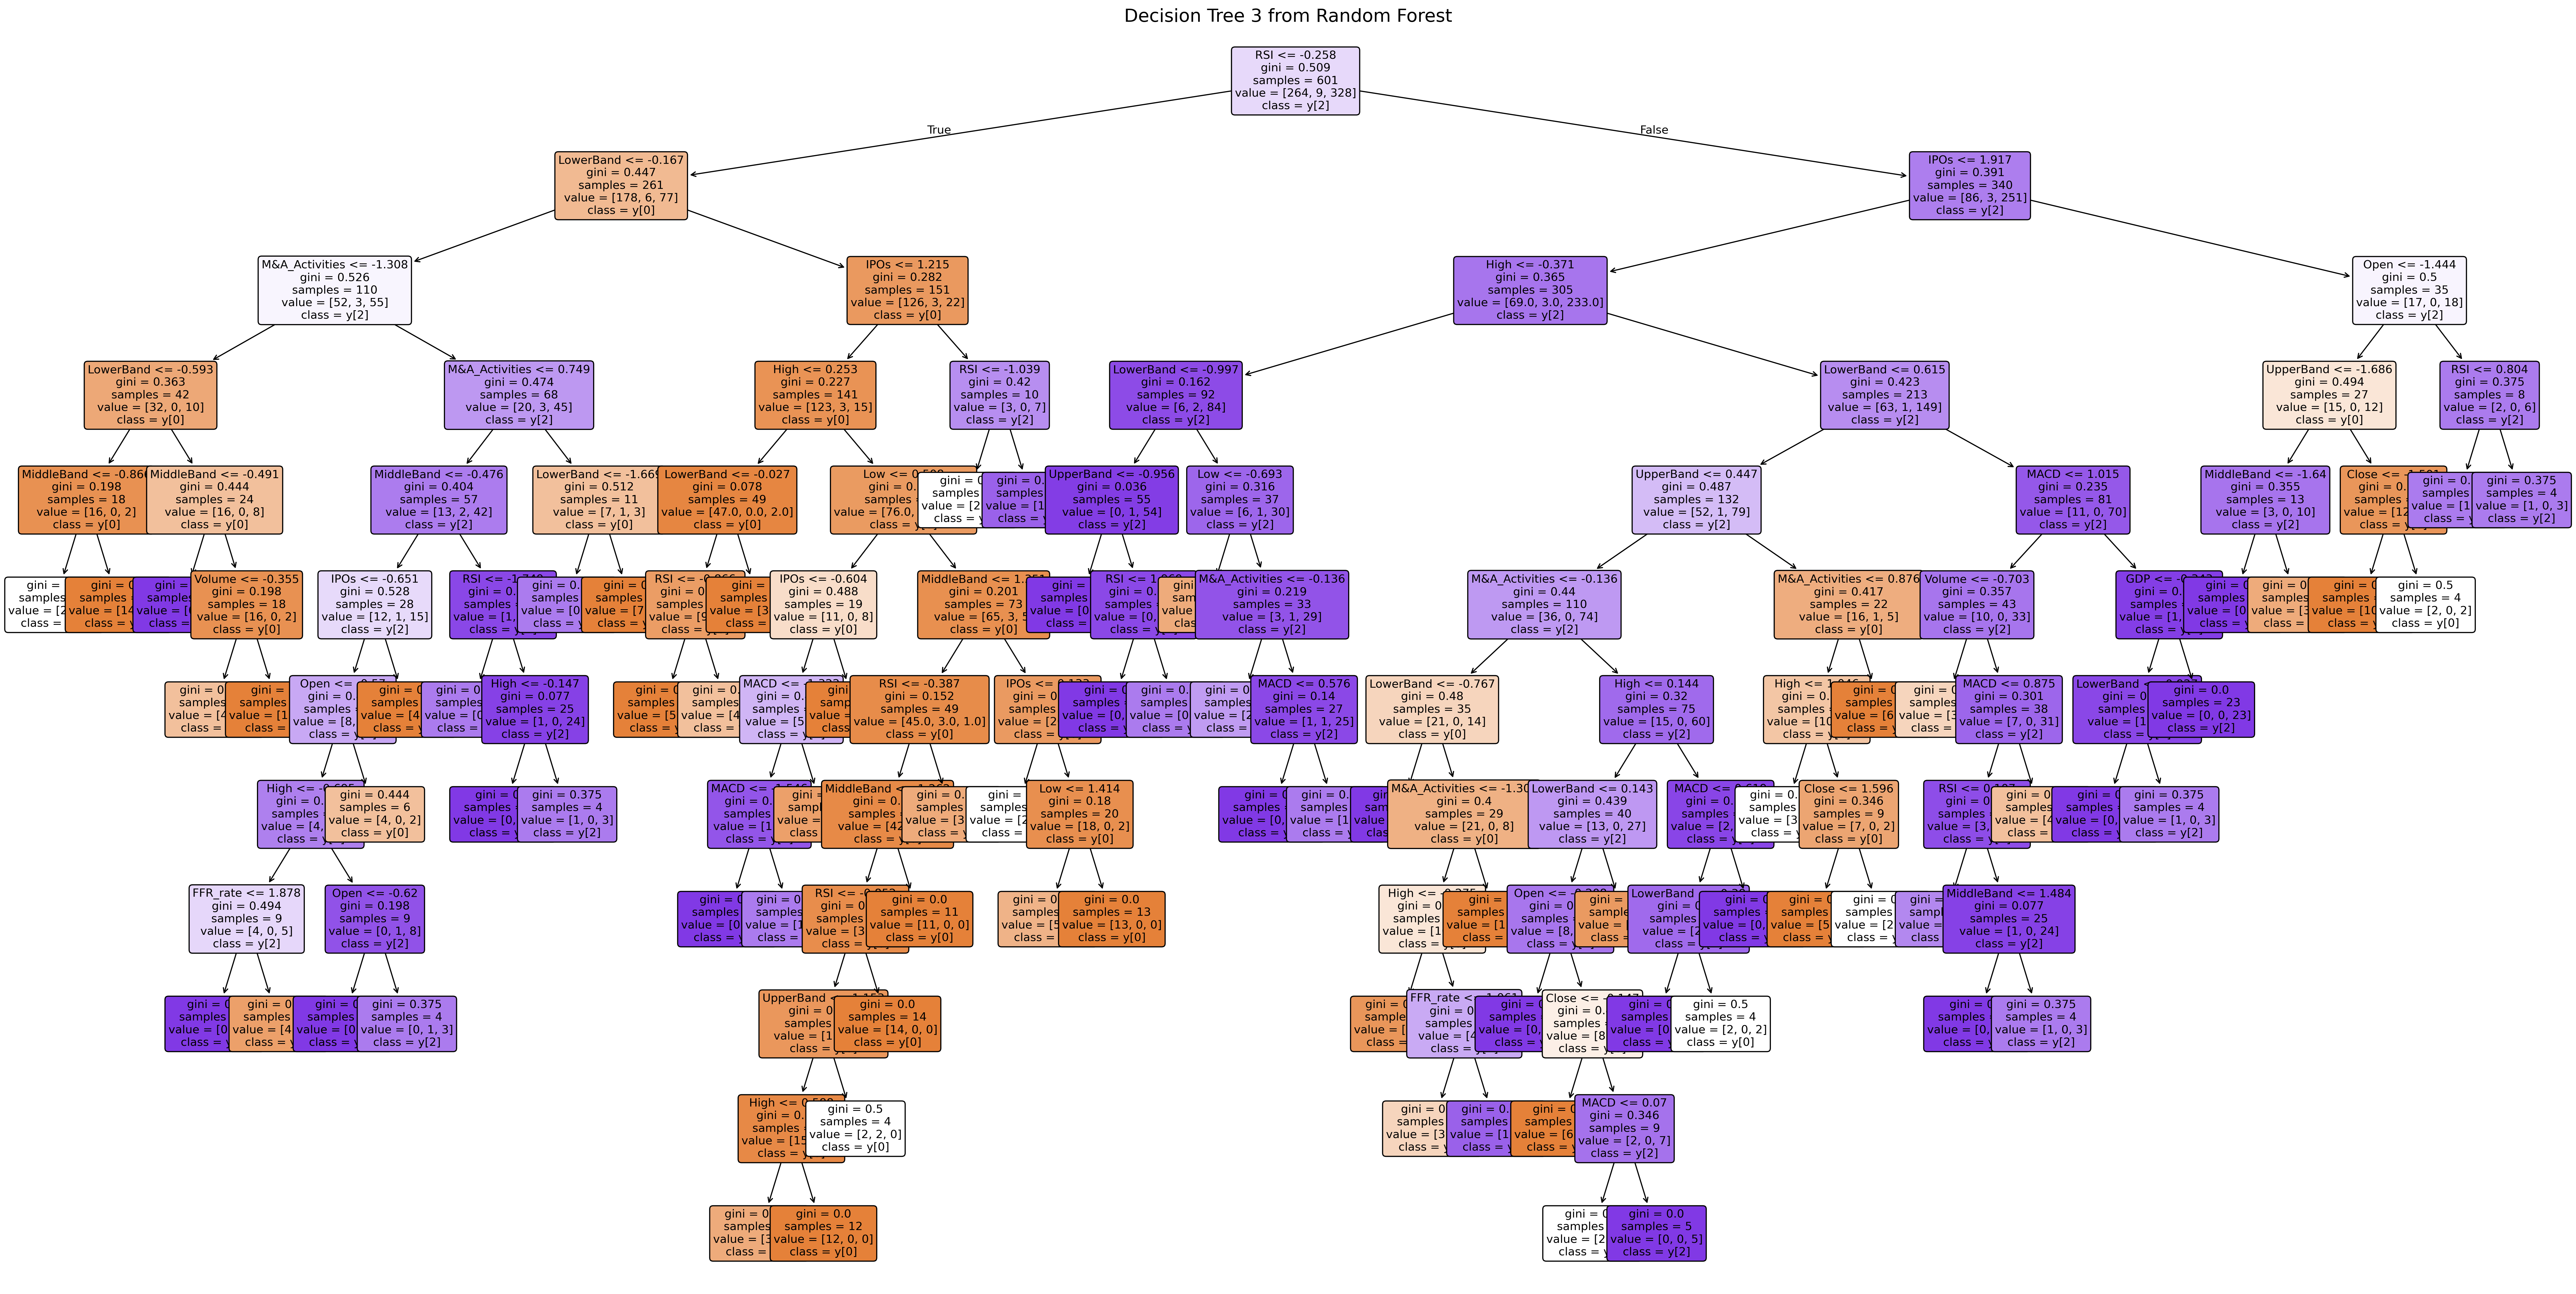

In [19]:
from sklearn.tree import plot_tree
def visualize_random_forest_tree(rf_model, feature_names, tree_index=0):
    plt.figure(figsize=(40, 20), dpi=300)
    # Extract one tree from the Random Forest
    tree = rf_model.estimators_[tree_index]
    plot_tree(tree, feature_names=feature_names, filled=True, rounded=True, class_names=True, fontsize=10)
    plt.title(f"Decision Tree {tree_index + 1} from Random Forest", fontsize=16)
    plt.show()
visualize_random_forest_tree(best_rf_clf, feature_columns, 2)


Running backtest for APO...


[*********************100%***********************]  1 of 1 completed
c:\Anaconda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[*********************100%***********************]  1 of 1 completed
c:\Anaconda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Running backtest for CG...
Running backtest for KKR...


[*********************100%***********************]  1 of 1 completed
c:\Anaconda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[*********************100%***********************]  1 of 1 completed


Running backtest for ARES...


c:\Anaconda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


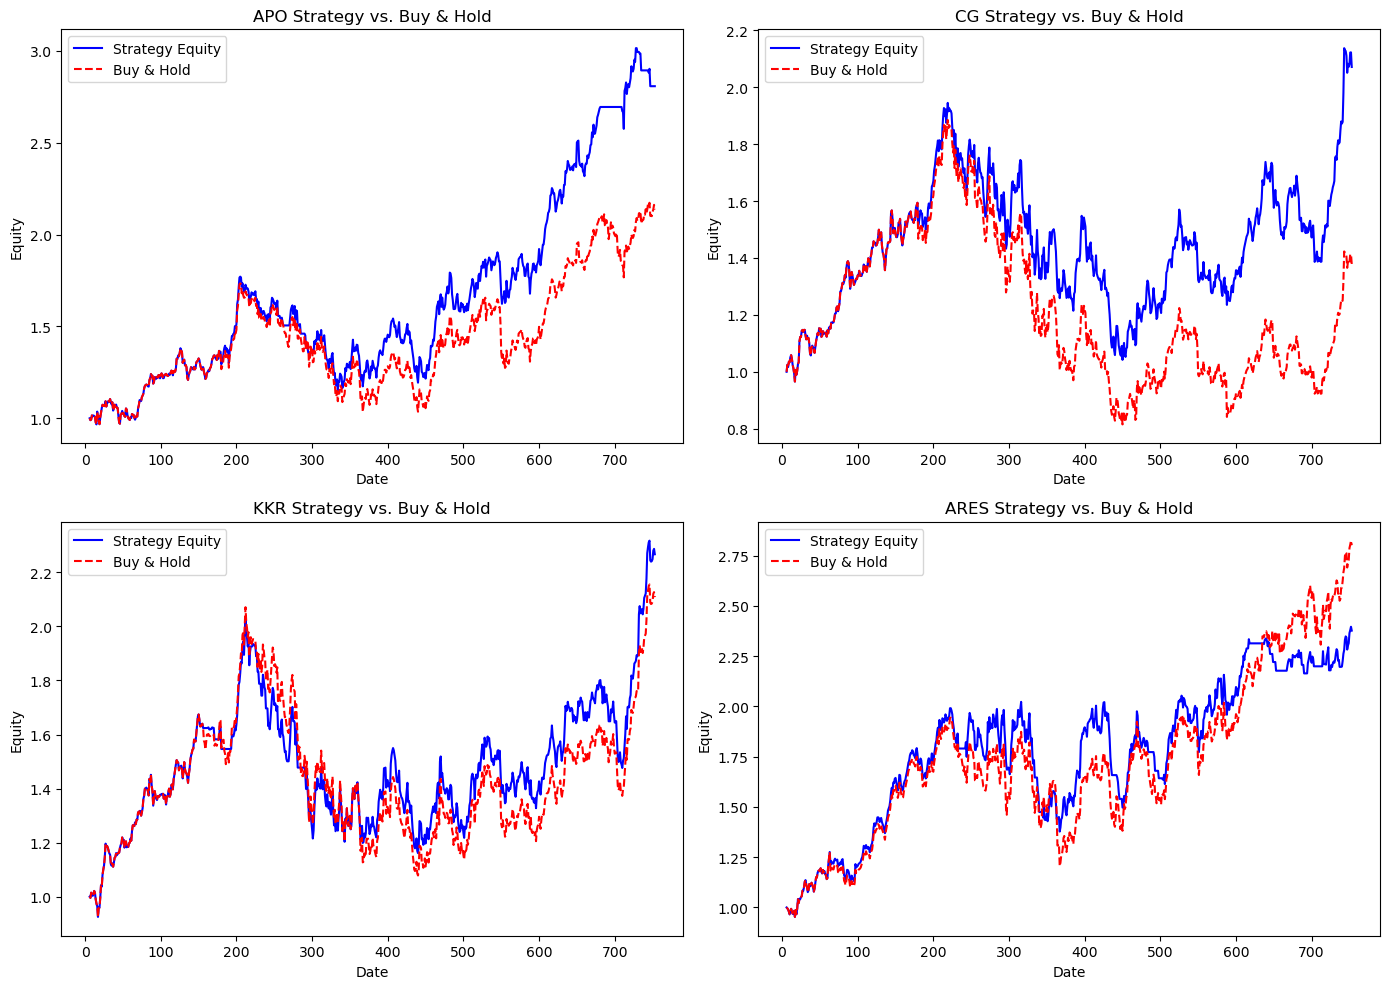

In [ ]:
import matplotlib.pyplot as plt

#Backtesting Calculation Model: 
def backtest_rf_model(ticker, start_date, end_date, model, scaler, feature_columns, macro, lookback=5):
    data = yf.download(ticker, start=start_date, end=end_date)

    data["RSI"] = RSI(data, period=14)
    data = MACD(data, short_period=7, long_period=17, signal_period=9)
    data = Bollinger_Bands(data, period=20, std_multiplier=2)

    data.reset_index(drop=True, inplace=True)
    data.index = data.index + 1

    data_clean = data.copy()
    data_clean.columns = data_clean.columns.droplevel(1)
    data_final = data_clean.join(macro)

    data_clean_features = data_final[feature_columns].copy()
    data_clean_features[feature_columns] = scaler.transform(data_clean_features[feature_columns])

    X_test = data_clean_features.iloc[lookback:].values
    predicted_labels = model.predict(X_test)

    data_final = data_final.iloc[lookback:].copy()
    data_final["Predicted Signal"] = predicted_labels

    return data_final

#Equity trade backtesting:
def calculate_equity_trade_backtest(df):
    df = df.copy()
    df["Position"] = np.nan
    df.loc[df["Predicted Signal"] == 2, "Position"] = 1
    df.loc[df["Predicted Signal"] == 0, "Position"] = 0
    df.loc[df["Predicted Signal"] == 1, "Position"] = df["Position"].shift(1)
    df["Position"] = df["Position"].ffill().fillna(0).astype(int)
    df["daily_return"] = df["Close"].pct_change().fillna(0)
    df["strategy_return"] = df["daily_return"] * df["Position"].shift(1).fillna(0)
    df["strategy_return"] = np.clip(df["strategy_return"], -0.05, 0.10)
    df["strategy_equity"] = (1 + df["strategy_return"]).cumprod()
    df["buy_hold_equity"] = (1 + df["daily_return"]).cumprod().fillna(1)
    return df

#Visualizations: 
stocks = ["APO", "CG", "KKR", "ARES"]
start_date = "2021-01-01"
end_date = "2024-01-01"
equity_curves = {}

for stock in stocks:
    print(f"Running backtest for {stock}...")
    backtest_results = backtest_rf_model(stock, start_date, end_date, best_rf_clf, scaler, feature_columns, macro)
    backtest_results = calculate_equity_trade_backtest(backtest_results)
    equity_curves[stock] = {
        "strategy": backtest_results["strategy_equity"],
        "buy_hold": backtest_results["buy_hold_equity"],
        "dates": backtest_results.index
    }

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, stock in enumerate(stocks):
    ax = axes[i]
    ax.plot(equity_curves[stock]["dates"], equity_curves[stock]["strategy"], label="Strategy Equity", color="blue")
    ax.plot(equity_curves[stock]["dates"], equity_curves[stock]["buy_hold"], label="Buy & Hold", color="red", linestyle="dashed")
    ax.set_title(f"{stock} Strategy vs. Buy & Hold")
    ax.set_xlabel("Date")
    ax.set_ylabel("Equity")
    ax.legend()

plt.tight_layout()
plt.show()


3) PORTFOLIO OPTIMIZATION / RISK MANAGEMENT

In [21]:
import pandas as pd

strategy_returns = pd.DataFrame()
investment_stocks = ["APO", "CG","KKR", "ARES"]
for stock in investment_stocks: 
    equity = equity_curves[stock]["strategy"]
    returns = equity.pct_change().fillna(0)
    strategy_returns[stock] = returns
expected_returns = strategy_returns.mean()
cov_matrix = strategy_returns.cov()

In [22]:
import cvxpy as cp
import numpy as np

n = len(investment_stocks)
w = cp.Variable(n)
ret = expected_returns.values
cov = cov_matrix.values

objective = cp.Minimize(cp.quad_form(w, cov)) 
constraints = [
    cp.sum(w) == 1,
    w >= 0
]

prob = cp.Problem(objective, constraints)
prob.solve()

optimal_weights = w.value
optimal_weights[np.abs(optimal_weights) < 1e-8] = 0
portfolio_returns = strategy_returns.dot(optimal_weights)
portfolio_equity = (1 + portfolio_returns).cumprod()

In [23]:
optimal_weights

array([0.34249558, 0.08402453, 0.07326732, 0.50021258])

In [24]:
strategy_returns.corr()


APO        CG       KKR      ARES
APO   1.000000  0.636839  0.688605  0.615670
CG    0.636839  1.000000  0.767641  0.652231
KKR   0.688605  0.767641  1.000000  0.663449
ARES  0.615670  0.652231  0.663449  1.000000

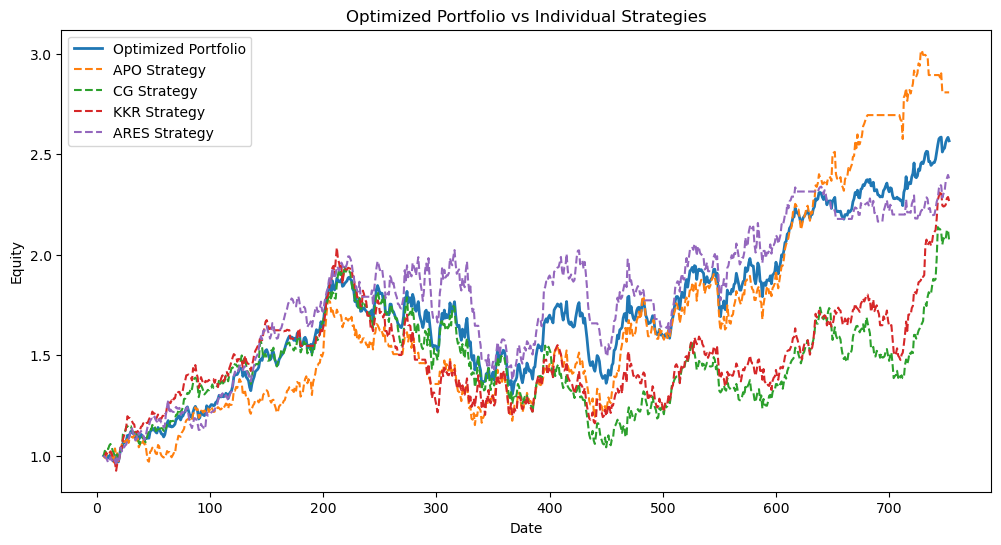

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(strategy_returns.index, portfolio_equity, label="Optimized Portfolio", linewidth=2)

for stock in investment_stocks:
    plt.plot(equity_curves[stock]["dates"], equity_curves[stock]["strategy"], label=f"{stock} Strategy", linestyle="--")

plt.title("Optimized Portfolio vs Individual Strategies")
plt.xlabel("Date")
plt.ylabel("Equity")
plt.legend()
plt.show()